# ODE

We will solve the following linear Cauchy model

\begin{align}
y^{\prime}(t) &= \lambda y(t)\\
y(0) & = 1
\end{align}

whose exact solution is

$$
y(t) = e^{\lambda t}
$$


In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg
import numpy.linalg

l = -5.#lambda
t0 = 0.
tf = 10.
y0 = 1.

s = linspace(t0,tf,5000)

exact = lambda x: exp(l*x)



### Forward Euler

$$
\frac{y_{n}-y_{n-1}}{h} = f(y_{n-1}, t_{n-1})
$$

4461.299878256778


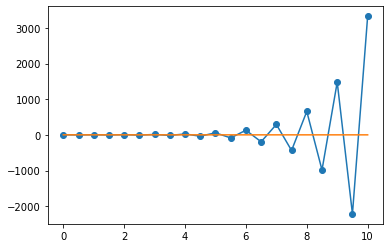

In [5]:
def fe(l,y0,t0,tf,h): #conditionally stable
    timesteps = arange(t0,tf+1e-10, h)
    sol = zeros_like(timesteps)
    sol[0] = y0
    for i in range(1,len(sol)):
        sol[i] = sol[i-1]*(1+l*h)
    
    return sol, timesteps

y, t = fe(l,y0,t0,tf,0.5)#diverging with 0.5: h must be < 2/5

_ = plot(t,y, 'o-')
_ = plot(s,exact(s))

error = numpy.linalg.norm(exact(t) - y, 2)
print(error)#0.21160539552547342 with h=0.1

### Backward Euler

$$
\frac{y_{n}-y_{n-1}}{h} = f(y_{n}, t_{n})
$$

h = 0.1, error = 1.5623814119124313
h = 0.2, error = 1.0489116667837806
h = 0.5, error = 0.5044985898372059
h = 0.8, error = 0.1861425545998223


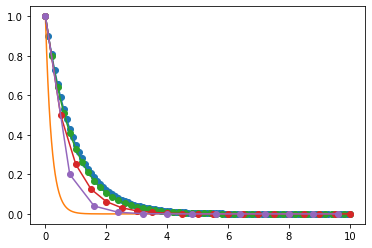

In [9]:
def be(l,y0,t0,tf,h): #unconditionally stable
    timesteps = arange(t0,tf+1e-10,h)
    sol = zeros_like(timesteps)
    sol[0] = y0
    for i in range(1,len(sol)):
        sol[i] = sol[i-1]*(1-l*h)
    
    return sol, timesteps

def polt(h, plot_exact=False):
    y, t = be(1, y0, t0, tf, h)
    
    _ = plot(t,y, '-o')
    if plot_exact:
        _ = plot(s, exact(s))
    error = linalg.norm(exact(t) - y, 2)
    print('h = {}, error = {}'.format(h,error))
    
polt(0.1, plot_exact=True)
polt(0.2)
polt(0.5)
polt(0.8)

### $\theta$-method

$$
\frac{y_{n}-y_{n-1}}{h} = \theta\, f(y_{n}, t_{n}) + (1-\theta)\,f(y_{n-1}, t_{n-1})
$$

0.0276016633936646


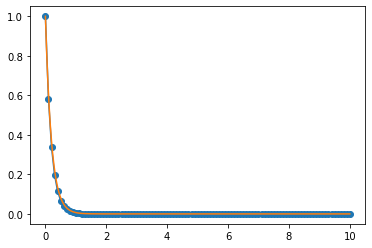

In [11]:
def tm(theta,l,y0,t0,tf,h): #combination of FE and BE
    timesteps = arange(t0,tf+1e-10,h)
    sol = zeros_like(timesteps)
    sol[0] = y0
    for i in range(1,len(sol)):
        sol[i] = theta*sol[i-1]/(1-l*h) + (1.-theta)*sol[i-1]*(1+l*h)
    
    return sol, timesteps

y,t = tm(0.5,l,y0,t0,tf,0.1)
_ = plot(t,y, 'o-')
_ = plot(s,exact(s))

error = linalg.norm(exact(t)-y,infty)
print(error)


### Simple adaptive time stepper

For each time step:
- Compute solution with CN
- Compute solution with BE
- Check the difference
- If the difference satisfy a given tolerance:
    - keep the solution of higher order
    - double the step size
    - go to the next step
- Else:
    - half the step size and repeat the time step

0.0008172984219047868 74


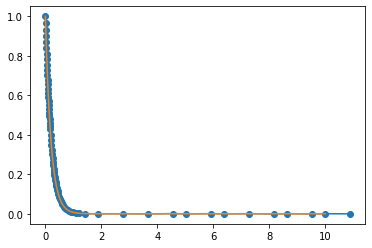

In [13]:
def adaptive(l,y0,t0,tf,h0, hmax=0.9,tol=1e-3):
    sol = []
    sol.append(y0)
    t = []
    t.append(t0)
    h = h0
    while t[-1] < tf:
        #print 'current t =', t[-1], '            h=', h
        current_sol = sol[-1]
        current_t = t[-1]
        sol_cn, _ = tm(0.5,l,current_sol,current_t, current_t + h, h)
        sol_be, _ = tm(1.,l,current_sol,current_t, current_t + h, h)
        
        if (abs(sol_cn[-1] - sol_be[-1]) < tol): #accept
            sol.append(sol_cn[-1])
            t.append(current_t+h)
            h *= 2.
            if h > hmax:
                h=hmax
        else:
            h /= 2.
            
    return sol, t

y,t = adaptive(l,y0,t0,tf,0.9)
_ = plot(t,y, 'o-')
_ = plot(s,exact(array(s)))

error = numpy.linalg.norm(exact(array(t)) - y, infty)
print(error, len(y))